# Road Accident Severity Analysis

This notebook explores UK road accident data from 2023 to investigate patterns in accident severity. We aim to:
- Understand the structure and quality of the dataset
- Identify statistical distributions and correlations
- Engineer useful features
- Build predictive models to classify severity
- Conduct geospatial hotspot analysis
- Evaluate the impact of spatial features on model performance

In [49]:
# Import required libraries

# Standard and system libraries
import os
import warnings
from pathlib import Path
import logging

# Data processing
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Statistical and correlation analysis
from scipy import stats
from sklearn.decomposition import PCA
from statsmodels.stats.multicomp import MultiComparison

# Machine learning
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Optional: SHAP (commented out)
# import shap

# Configure environment
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", context="notebook")

# Create output directories
Path("outputs").mkdir(parents=True, exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

## 1. Initial Data Inspection

We begin by loading the dataset and exploring its structure. This includes:
- Checking the shape and data types
- Viewing a sample of rows
- Examining summary statistics
- Identifying missing values and potentially low-value features

In [50]:
# Load the dataset
df = pd.read_csv('dft-road-casualty-statistics-collision-2023.csv', low_memory=False)

# Display the shape of the dataset
print(f"Dataset shape: Rows = {df.shape[0]}, Columns = {df.shape[1]}")

# Show the first 5 rows
df.head()

Dataset shape: Rows = 104258, Columns = 37


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision
0,2023010419171,2023,010419171,525060.0,170416.0,-0.202878,51.418974,1,3,1,1,01/01/2023,1,01:24,-1,E09000024,E09000024,5,0,2,20,9,4,5,0,2,5,4,8,2,0,0,1,1,2,E01003383,-1
1,2023010419183,2023,010419183,535463.0,198745.0,-0.042464,51.671155,1,3,3,2,01/01/2023,1,02:25,-1,E09000010,E09000010,6,0,6,30,3,4,6,0,0,1,4,1,1,0,0,1,1,2,E01001547,-1
2,2023010419189,2023,010419189,508702.0,177696.0,-0.435789,51.487777,1,3,2,1,01/01/2023,1,03:50,-1,E09000017,E09000017,3,437,1,30,1,4,6,0,0,0,4,1,1,0,0,1,1,2,E01002448,-1
3,2023010419191,2023,010419191,520341.0,190175.0,-0.263972,51.597575,1,3,2,1,01/01/2023,1,02:13,-1,E09000003,E09000003,3,5,6,30,3,4,6,0,0,0,4,9,1,0,0,1,1,2,E01000129,-1
4,2023010419192,2023,010419192,527255.0,176963.0,-0.168976,51.477324,1,3,2,1,01/01/2023,1,01:42,-1,E09000032,E09000032,3,3220,6,30,8,4,6,0,0,0,4,1,1,0,0,1,1,2,E01004583,-1


In [51]:
# Show basic info
df.info()

# Summary stats for numeric columns
df.describe(include=[np.number])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104258 entries, 0 to 104257
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               104258 non-null  object 
 1   accident_year                                104258 non-null  int64  
 2   accident_reference                           104258 non-null  object 
 3   location_easting_osgr                        104246 non-null  float64
 4   location_northing_osgr                       104246 non-null  float64
 5   longitude                                    104246 non-null  float64
 6   latitude                                     104246 non-null  float64
 7   police_force                                 104258 non-null  int64  
 8   accident_severity                            104258 non-null  int64  
 9   number_of_vehicles                           104258 non-nul

,accident_year,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,enhanced_severity_collision
count,104258.0,104246.000000,1.042460e+05,104246.000000,104246.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.0,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000,104258.000000
mean,2023.0,455388.583284,2.754993e+05,-1.204893,52.366984,27.638397,2.745996,1.820628,1.275461,4.129189,-1.0,4.225565,787.296054,5.294222,35.873602,4.632748,1.757745,3.104155,214.202354,0.509592,1.304629,2.025945,1.689808,1.415632,0.403537,0.345125,1.325404,1.518051,1.721479,1.614255
std,0.0,92264.787002,1.466000e+05,1.349407,1.320853,24.321077,0.467638,0.689053,0.737006,1.929225,0.0,1.464022,1578.472251,1.700894,14.349338,14.731899,2.552435,2.763917,916.212958,2.094497,2.643103,1.695939,1.885524,1.132241,1.837402,1.734161,0.469101,0.810553,0.794875,2.693744
min,2023.0,70537.000000,1.052800e+04,-7.429339,49.914528,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.000000,0.000000,1.000000,20.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000
25%,2023.0,393842.000000,1.748982e+05,-2.093077,51.460339,4.000000,3.000000,1.000000,1.000000,3.000000,-1.0,3.000000,0.000000,6.000000,30.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,-1.000000
50%,2023.0,462486.500000,2.149055e+05,-1.082364,51.819044,22.000000,3.000000,2.000000,1.000000,4.000000,-1.0,4.000000,31.000000,6.000000,30.000000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000
75%,2023.0,529489.250000,3.834275e+05,-0.134329,53.344464,45.000000,3.000000,2.000000,1.000000,6.000000,-1.0,6.000000,539.000000,6.000000,40.000000,3.000000,4.000000,6.000000,0.000000,0.000000,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000
max,2023.0,655160.000000,1.152174e+06,1.756018,60.252418,99.000000,3.000000,17.000000,70.000000,7.000000,-1.0,6.000000,9176.000000,9.000000,70.000000,99.000000,9.000000,6.000000,9999.000000,9.000000,9.000000,7.000000,9.000000,9.000000,9.000000,9.000000,3.000000,3.000000,2.000000,7.000000


In [52]:
# Summary stats for categorical columns
df.describe(include=['object', 'category'])

# Missing values (sorted)
missing_values = df.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

location_easting_osgr     12
location_northing_osgr    12
longitude                 12
latitude                  12
dtype: int64

In [53]:
# Identify low-value columns
single_value_cols = []
high_missing_cols = []
high_cardinality_cols = []

for col in df.columns:
    if df[col].dropna().nunique() <= 1:
        single_value_cols.append(col)
    if (df[col].isnull().sum() / len(df)) > 0.95:
        high_missing_cols.append(col)
    if df[col].nunique() > 0.9 * len(df):
        high_cardinality_cols.append(col)

print("Single-value columns:", single_value_cols)
print("High-missing columns (>95% missing):", high_missing_cols)
print("High-cardinality (likely IDs):", high_cardinality_cols)

Single-value columns: ['accident_year', 'local_authority_district']
High-missing columns (>95% missing): []
High-cardinality (likely IDs): ['accident_index', 'accident_reference', 'longitude', 'latitude']


## 1A. Distribution Analysis of Numerical Features

We visualise the distribution of each numerical feature to understand:
- Central tendency (mean, median)
- Spread (standard deviation)
- Skewness and outliers
This helps identify if data transformation is needed before modeling.

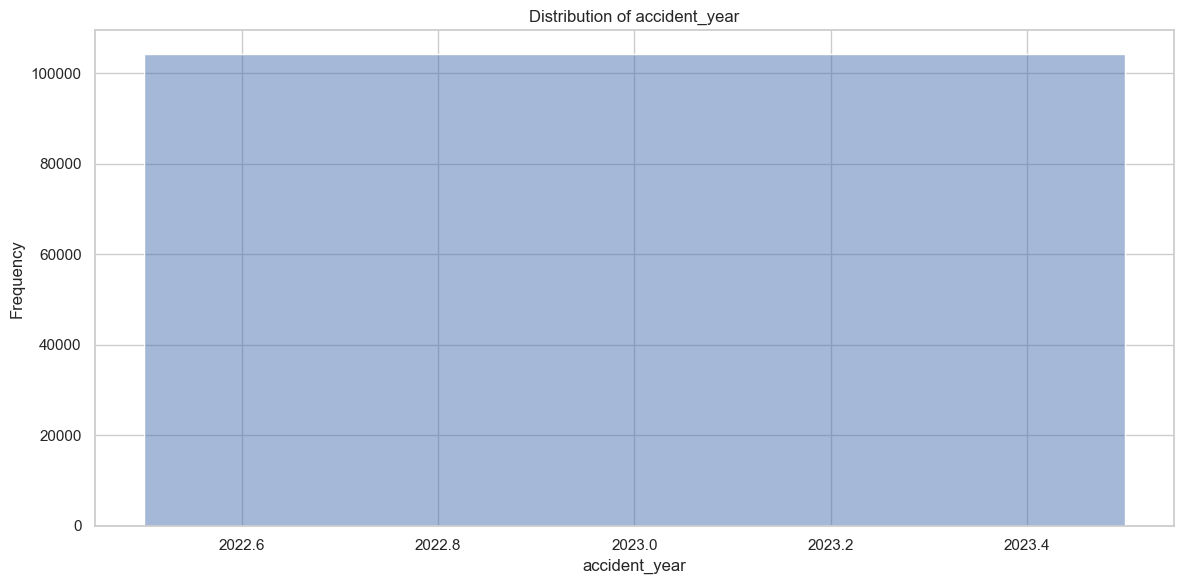

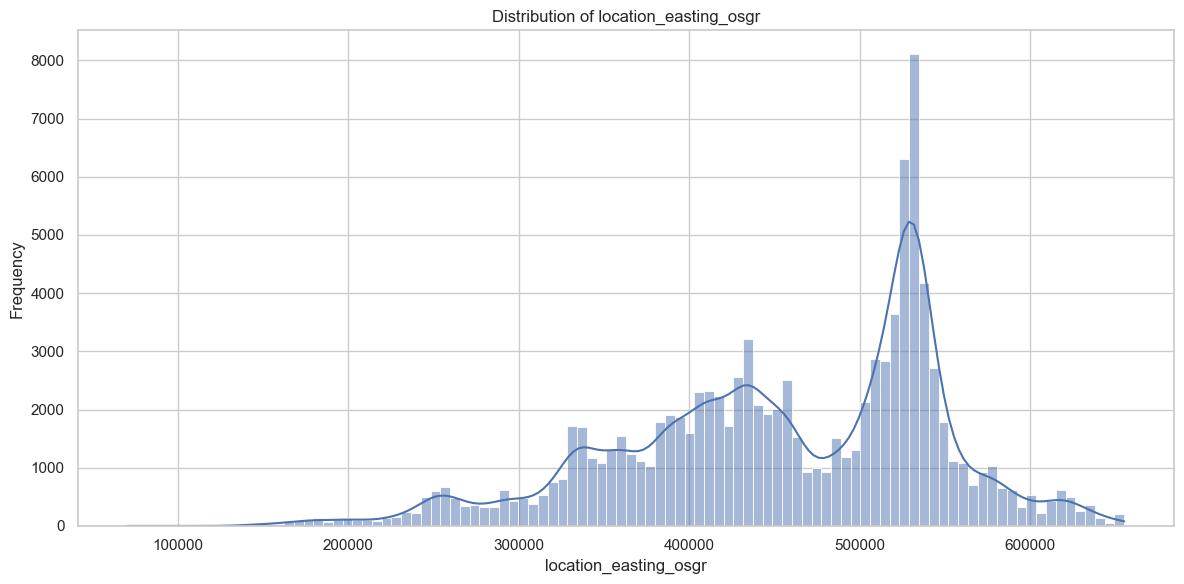

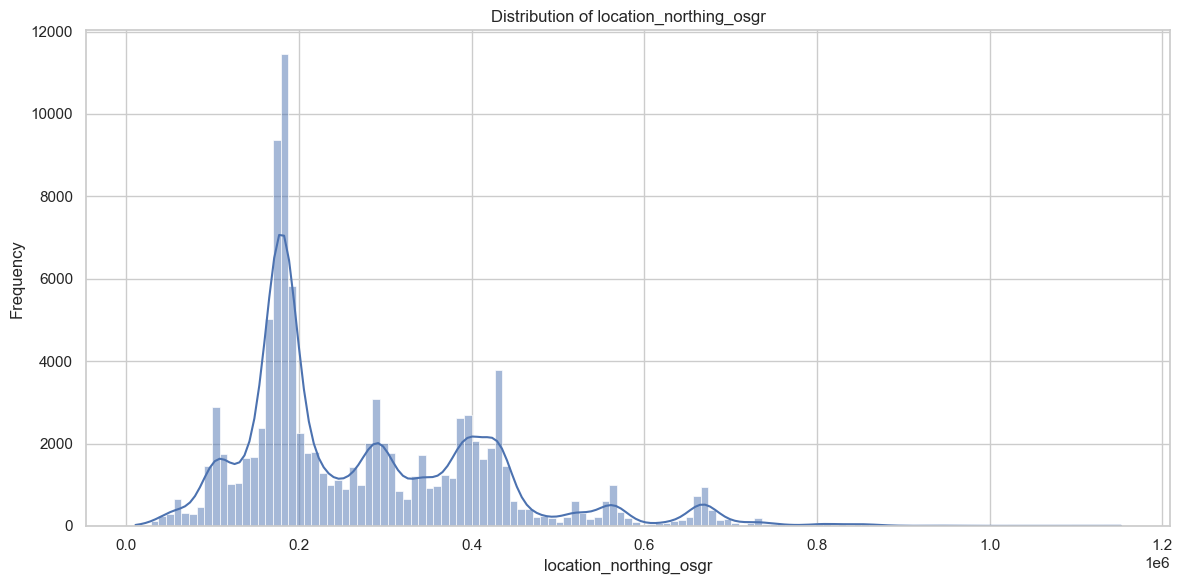

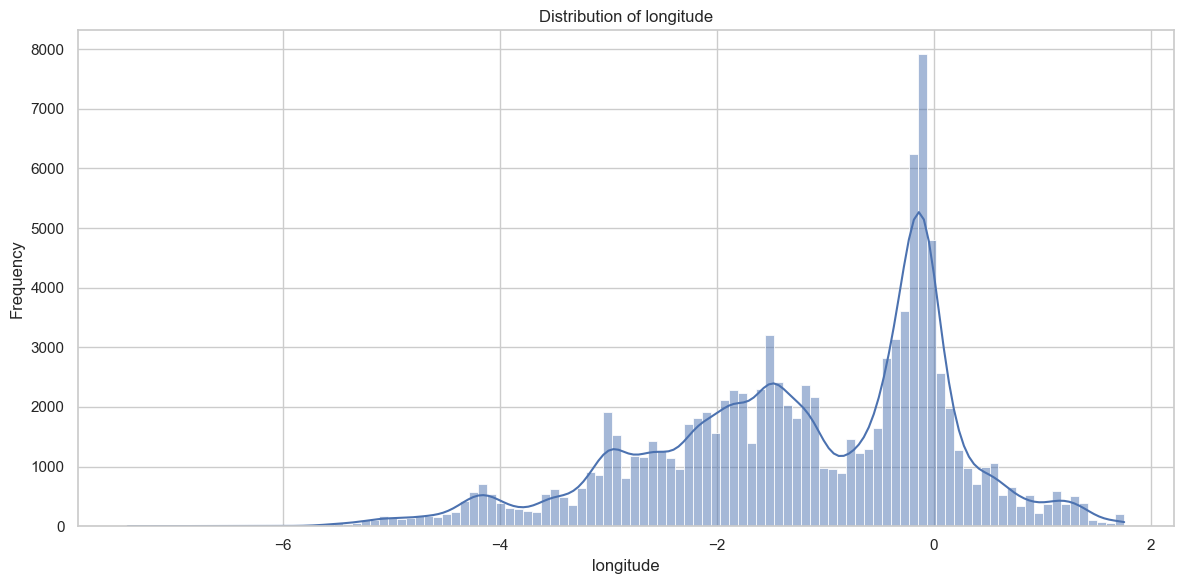

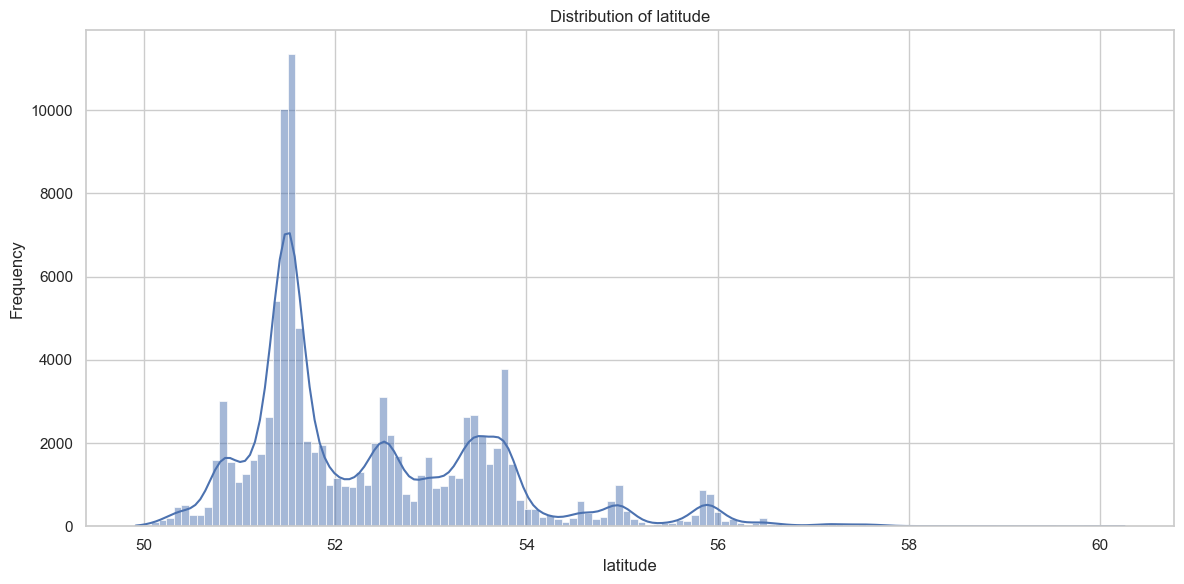

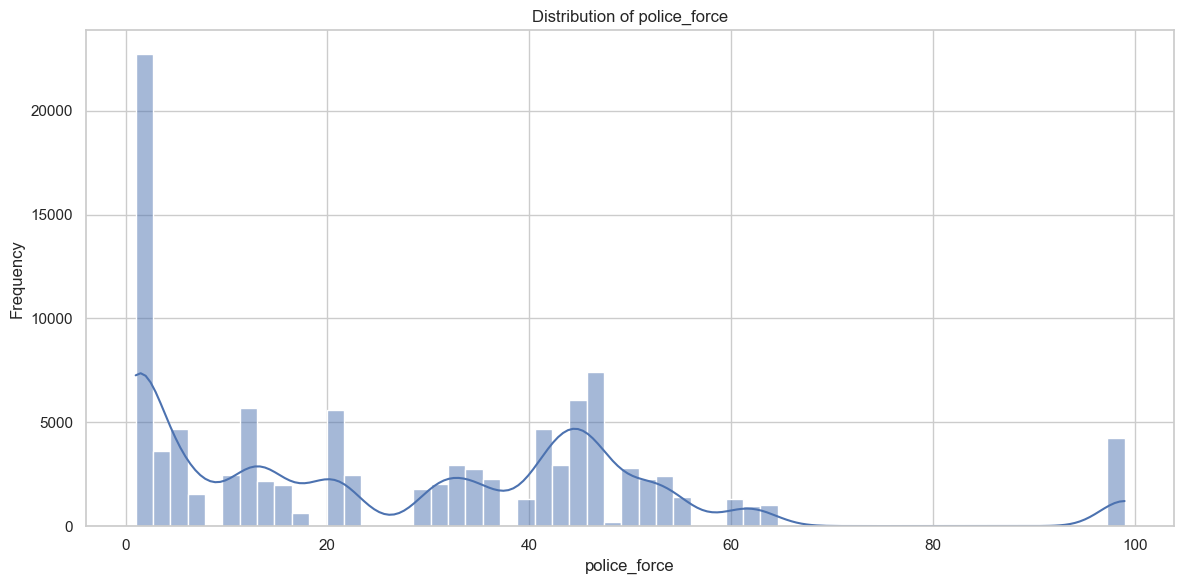

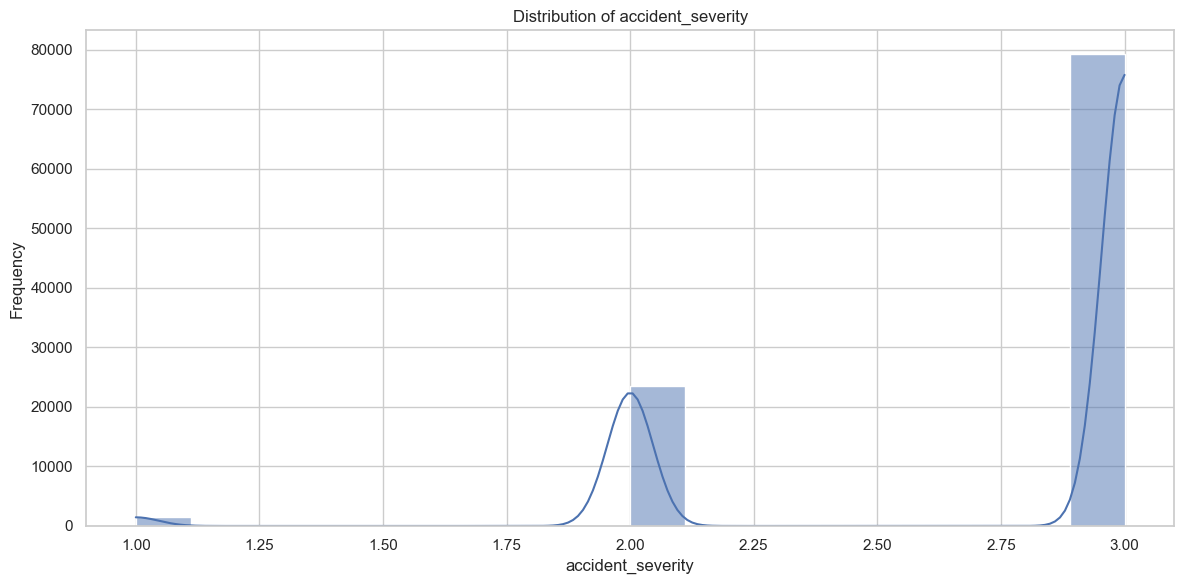

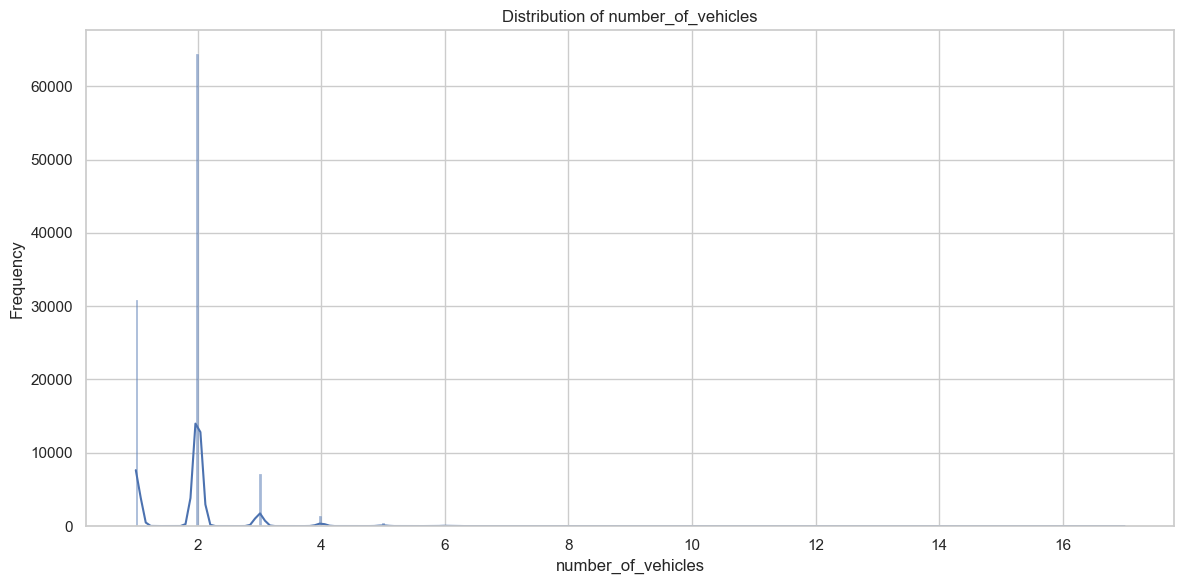

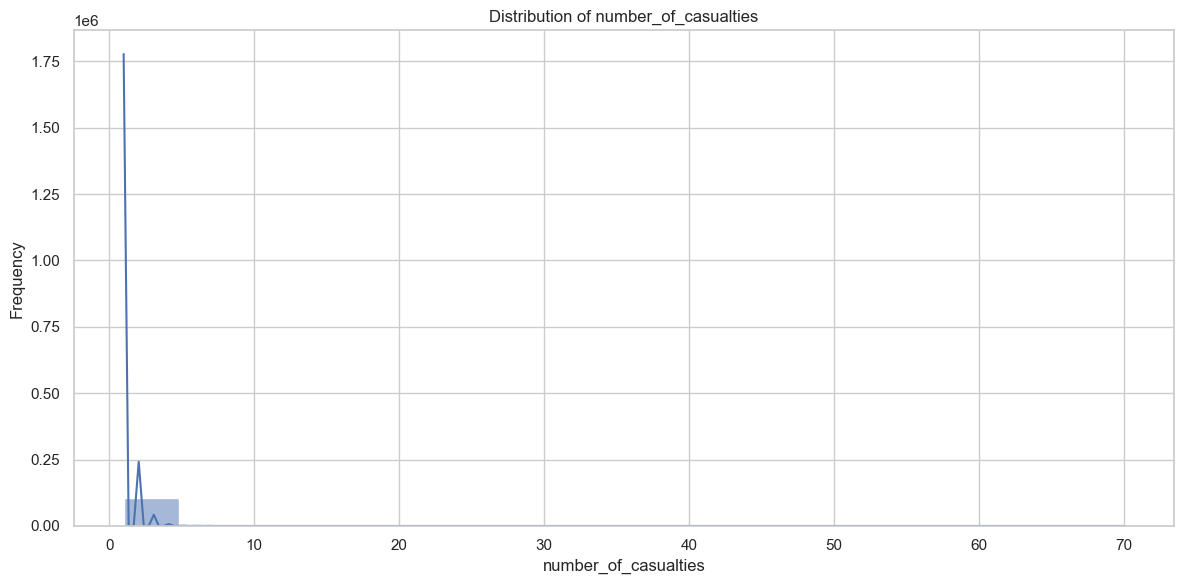

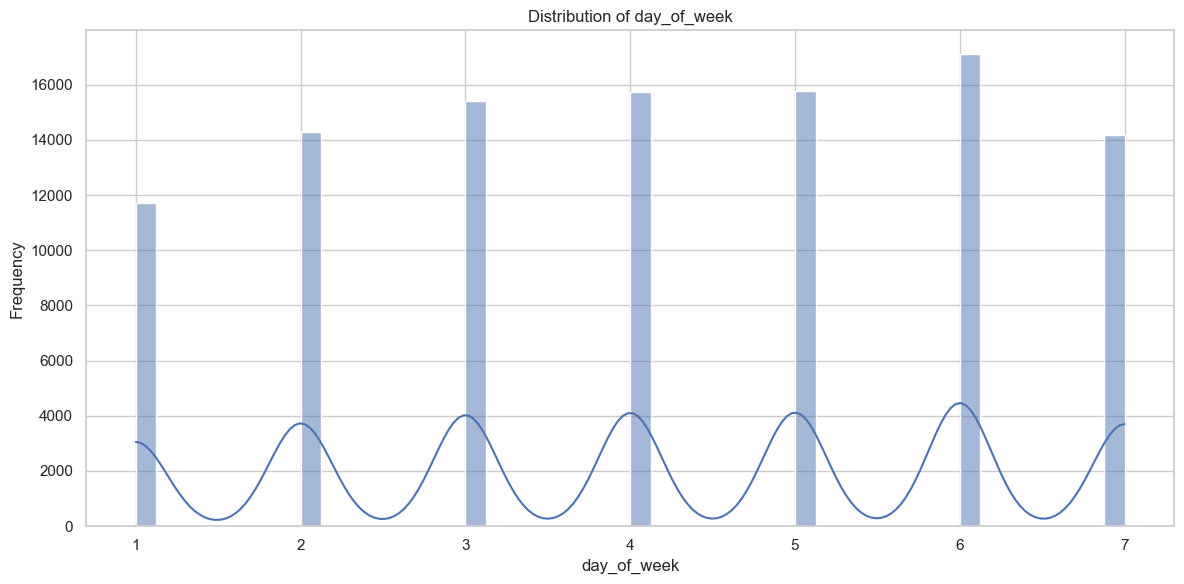

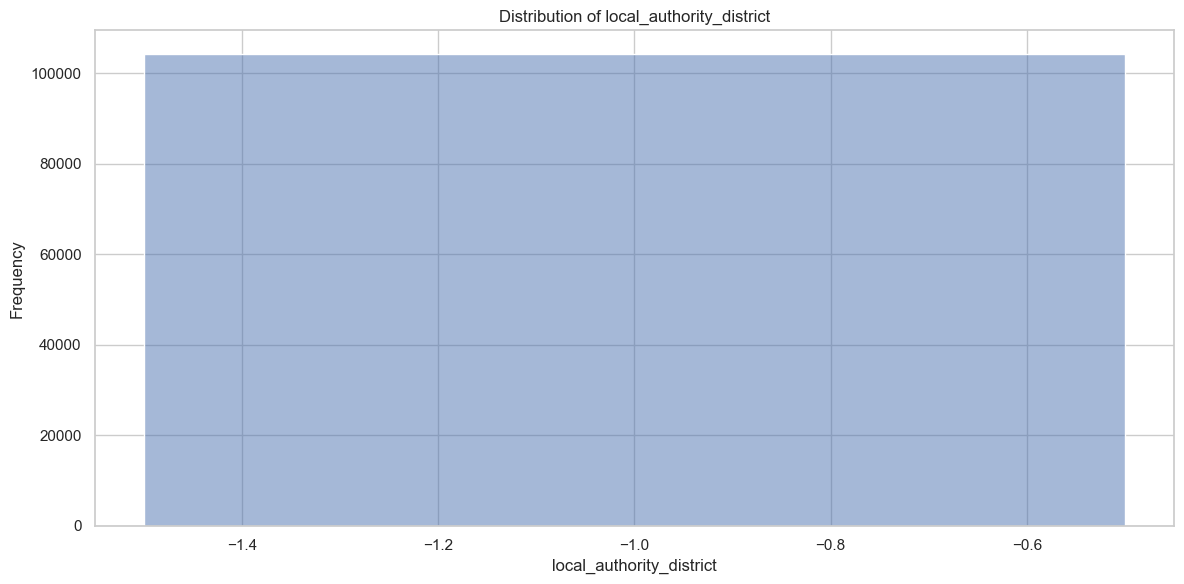

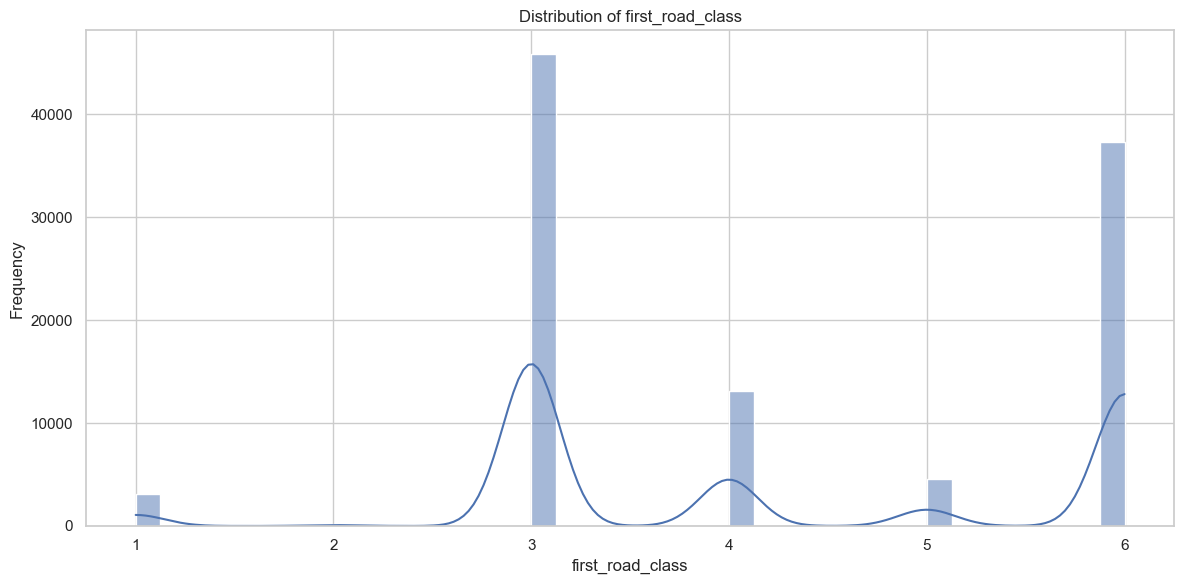

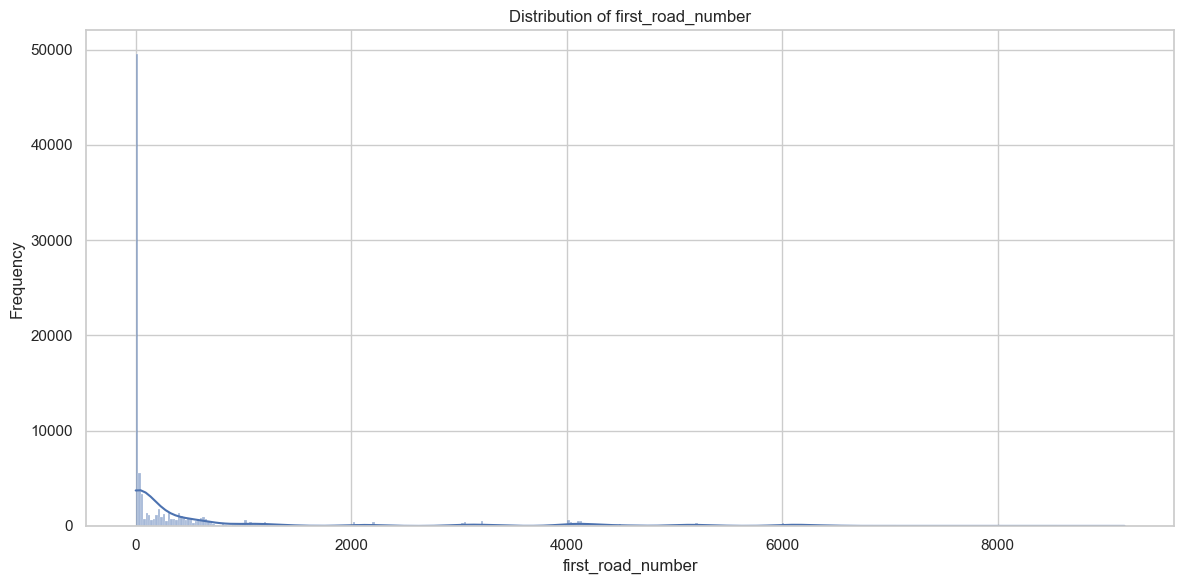

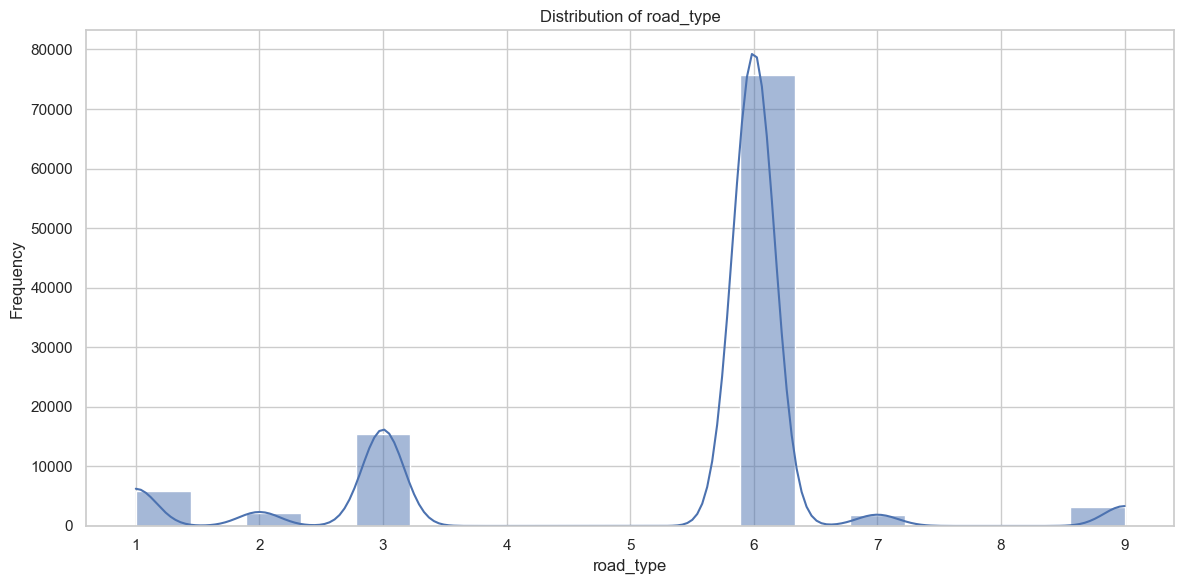

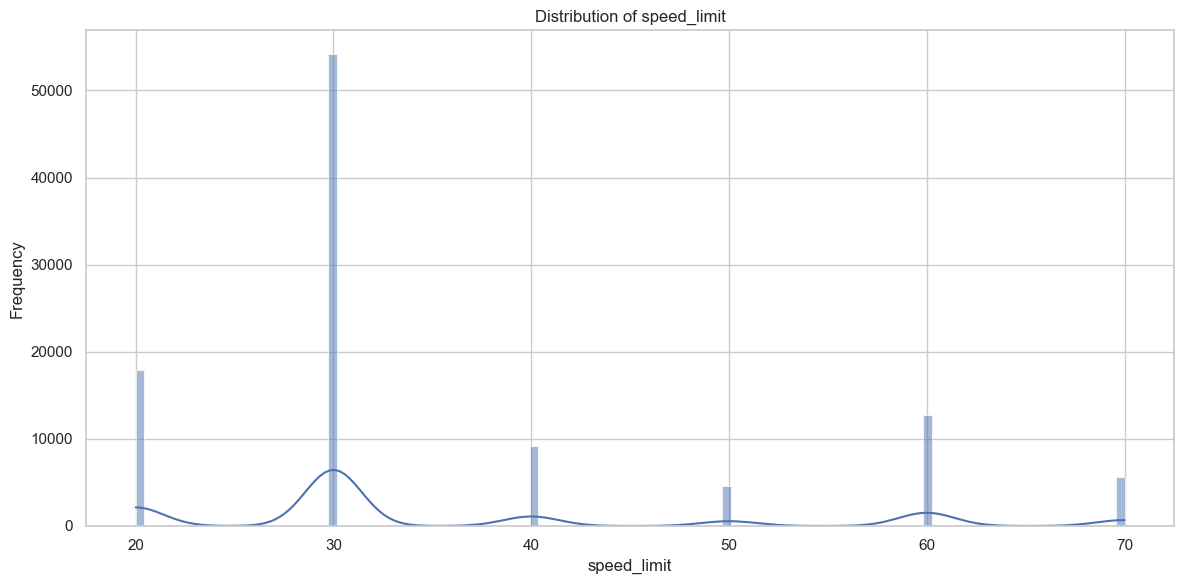

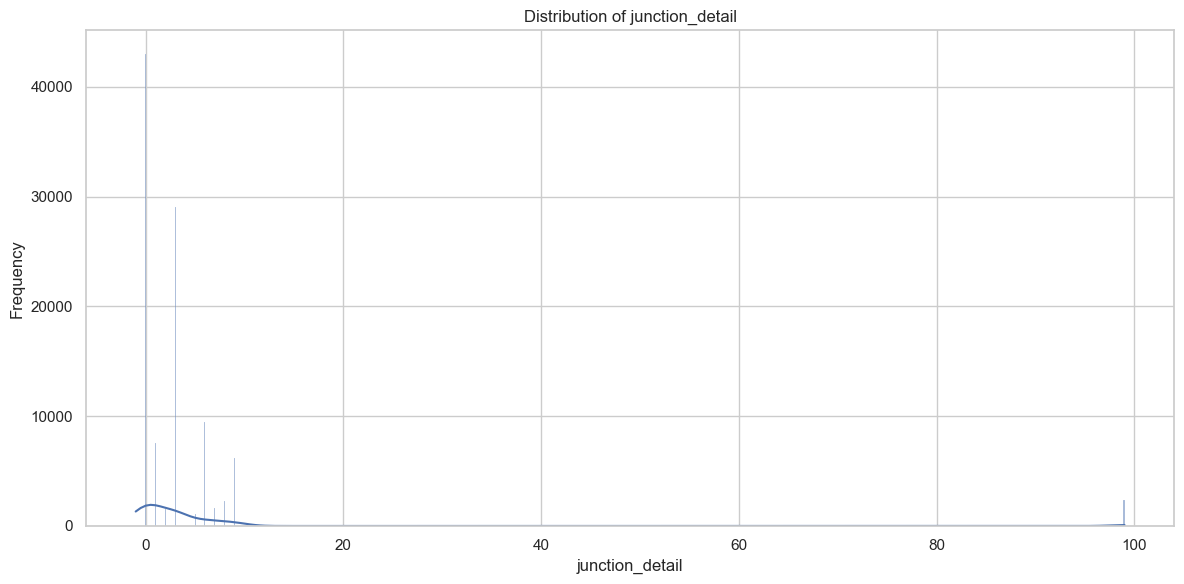

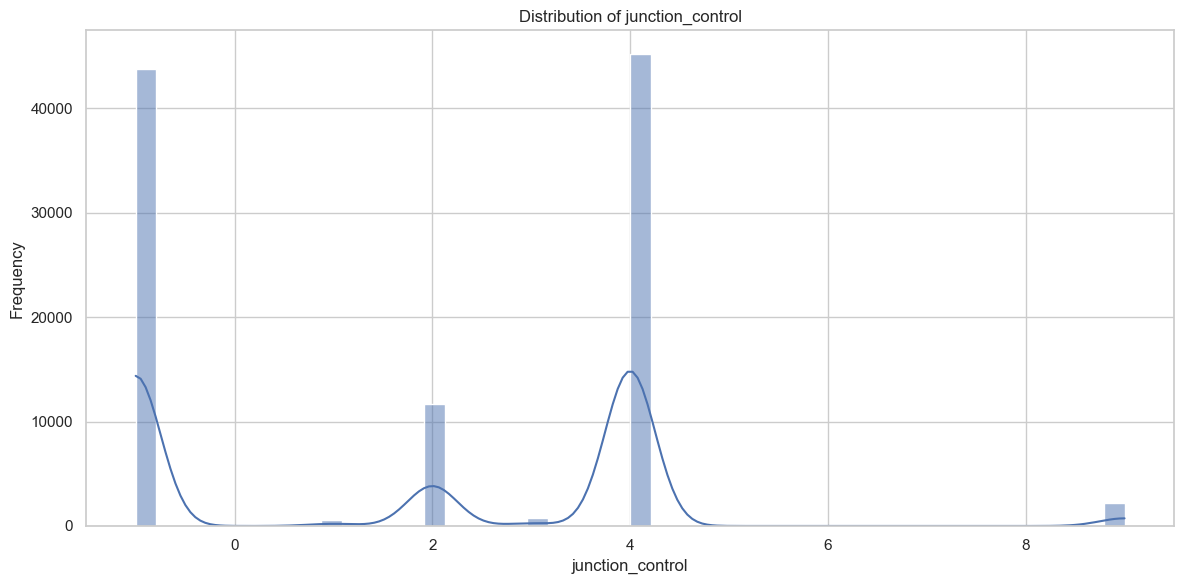

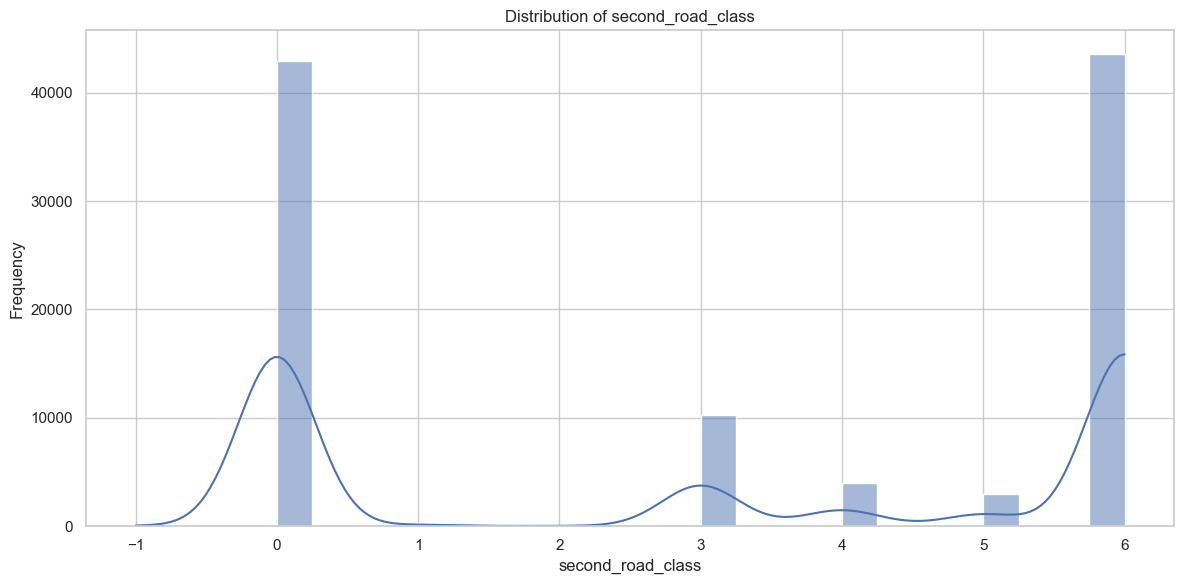

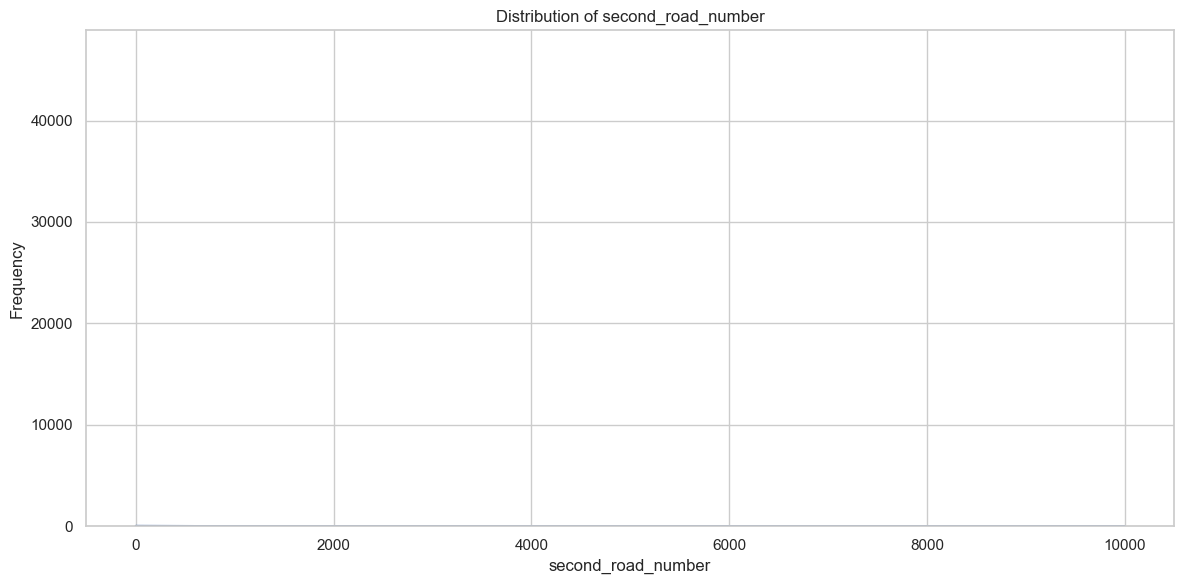

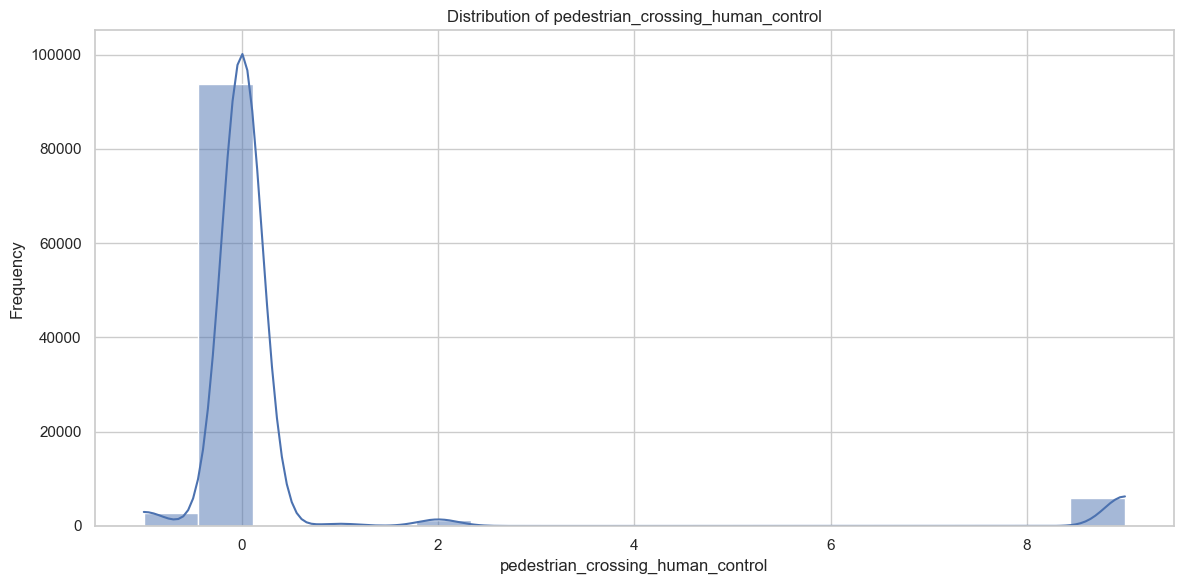

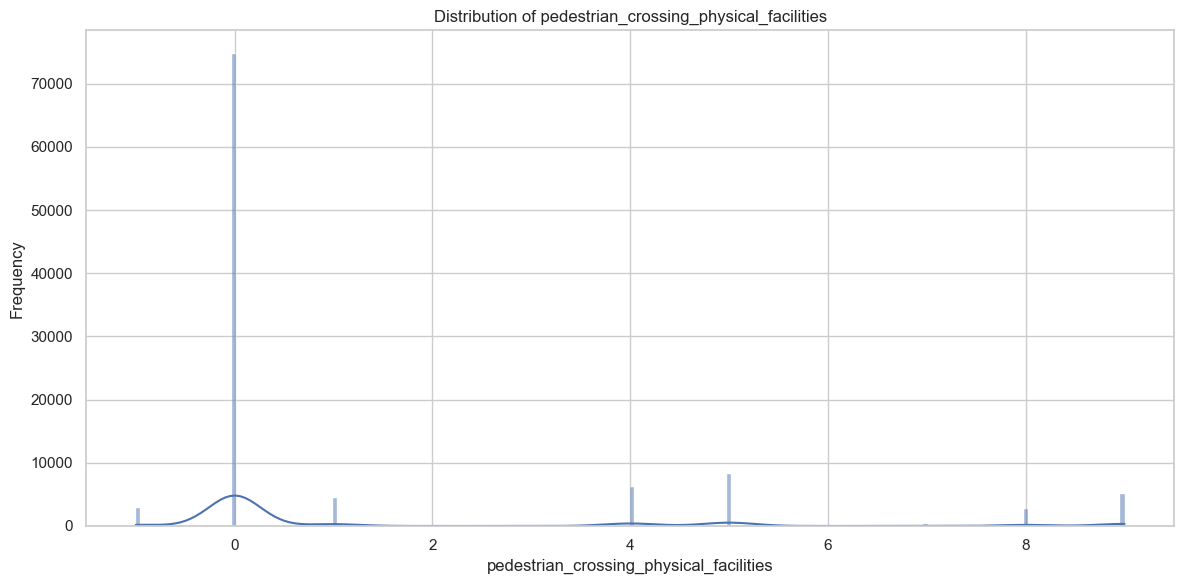

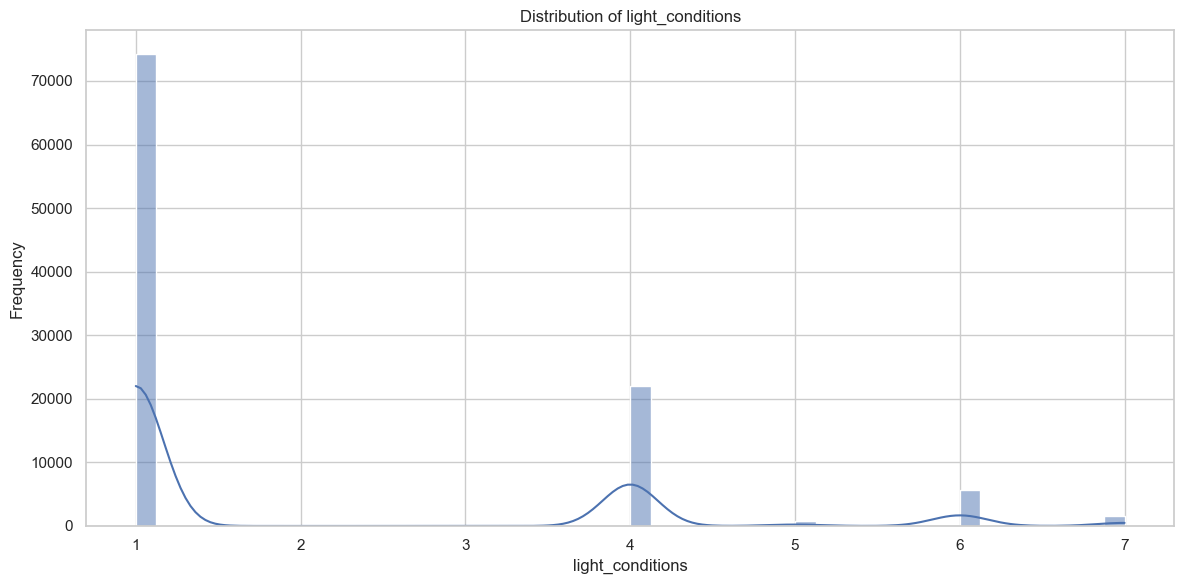

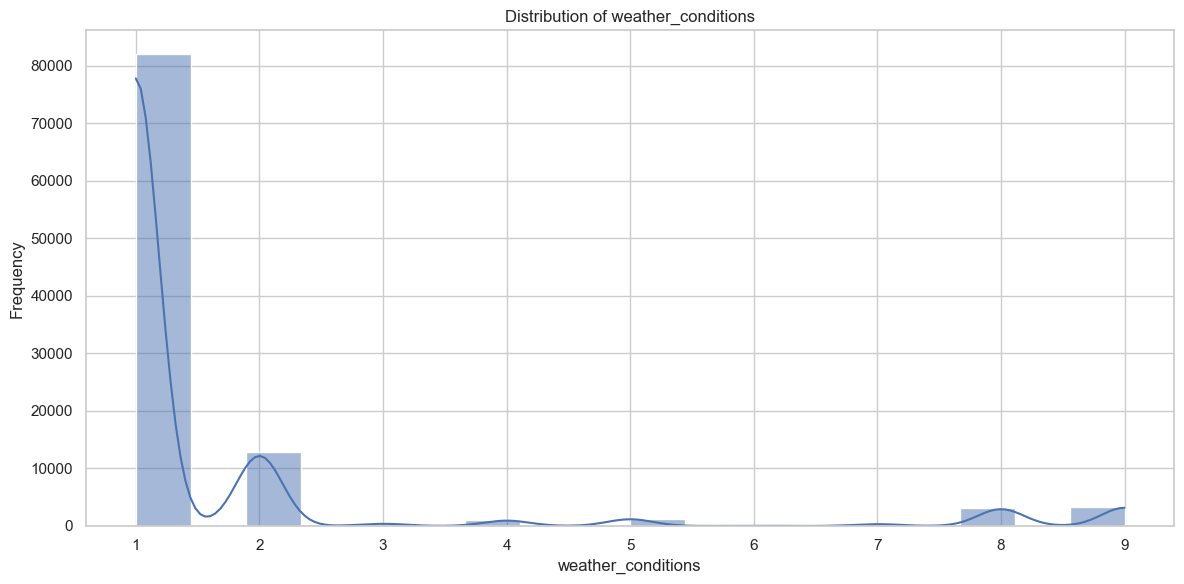

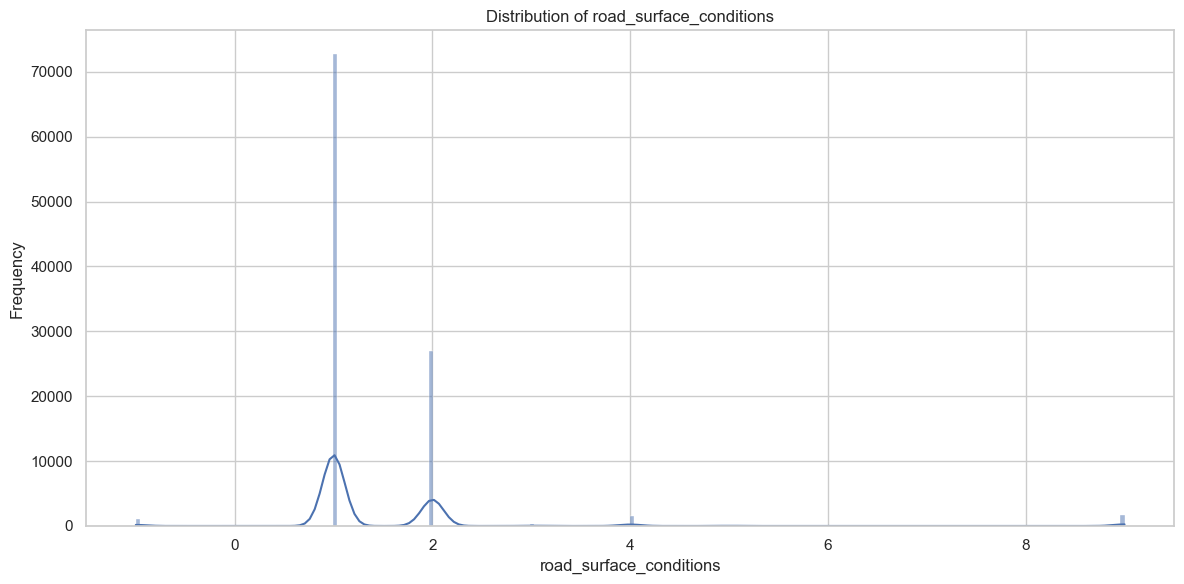

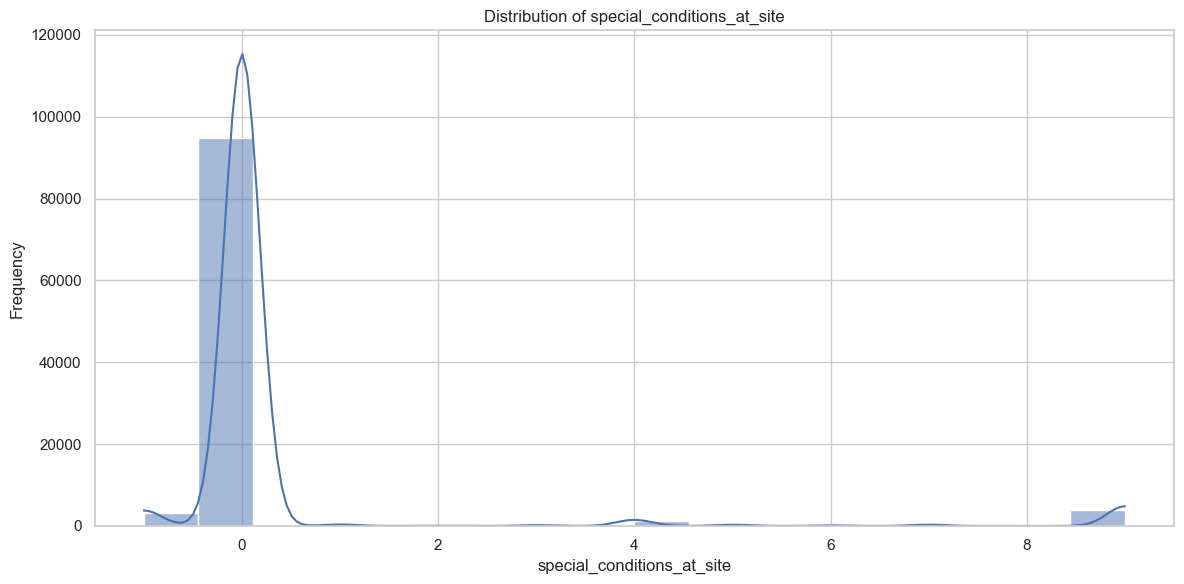

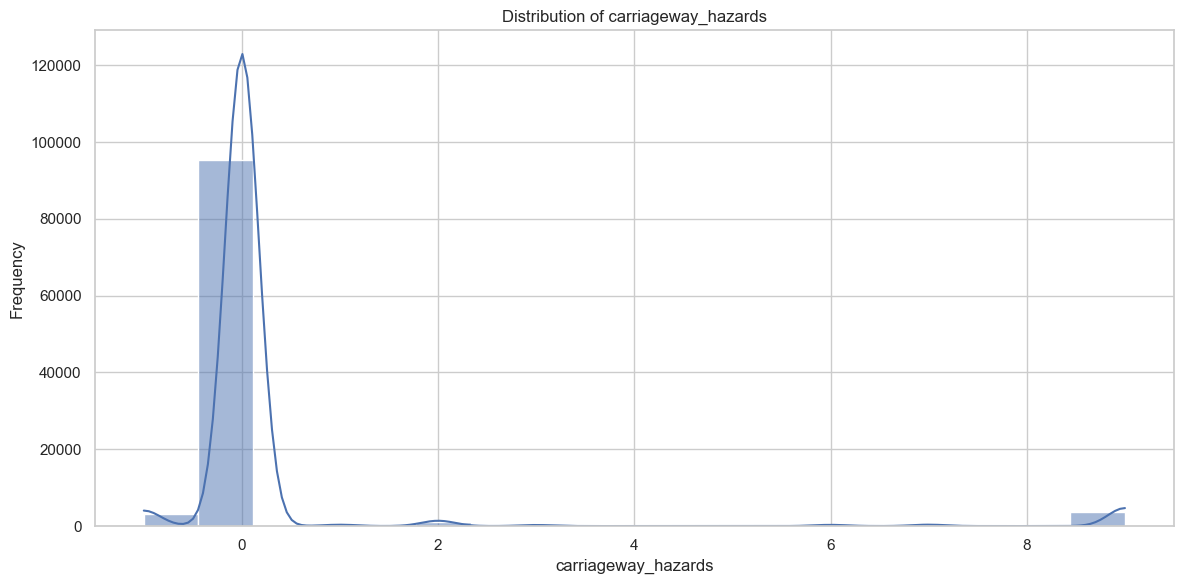

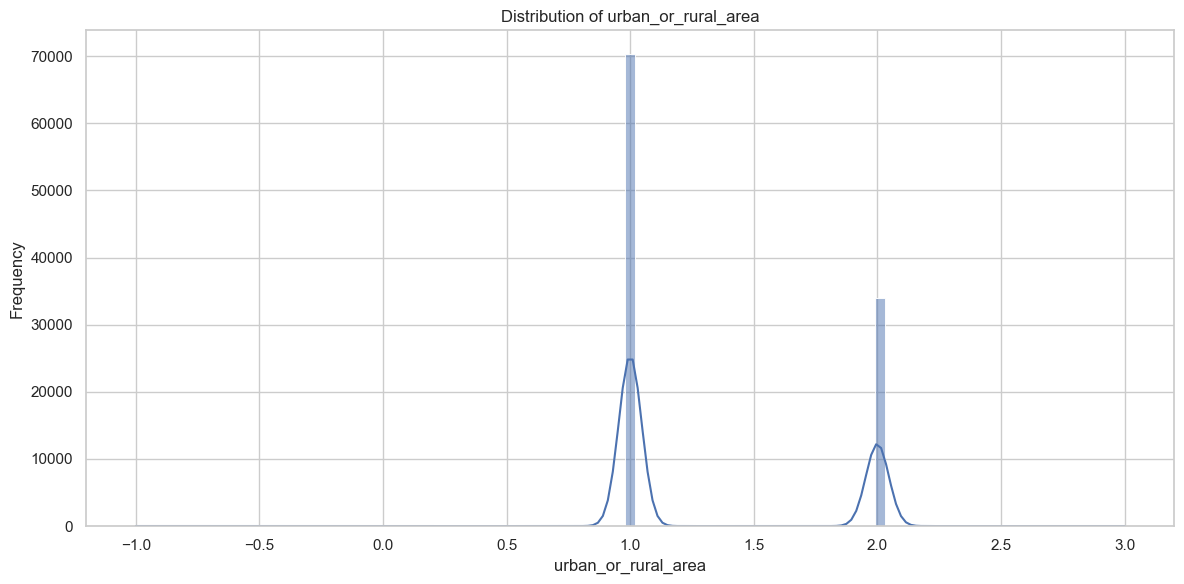

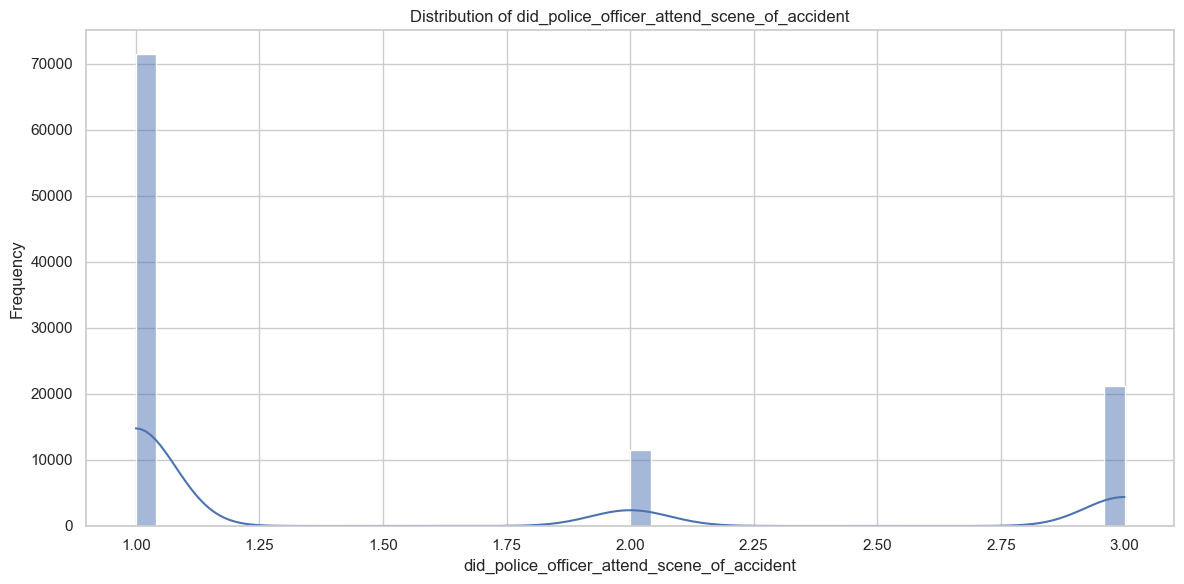

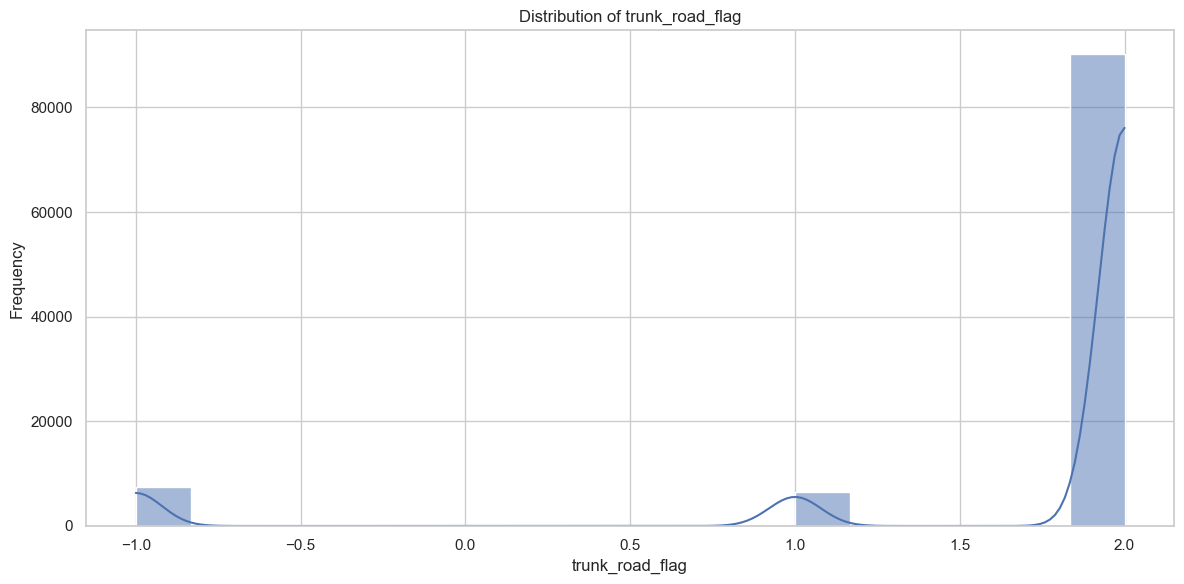

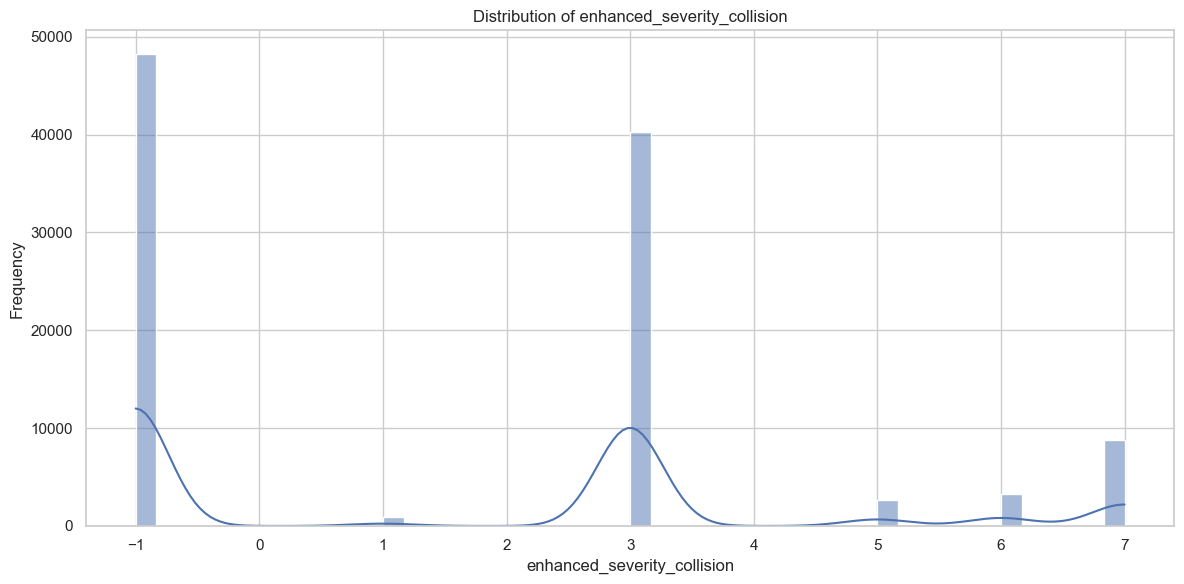

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = df.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## 1B. Categorical Feature Distributions

This section explores the frequency distribution of categorical variables. 
For features with many categories, only the top 10 values are visualised for readability.

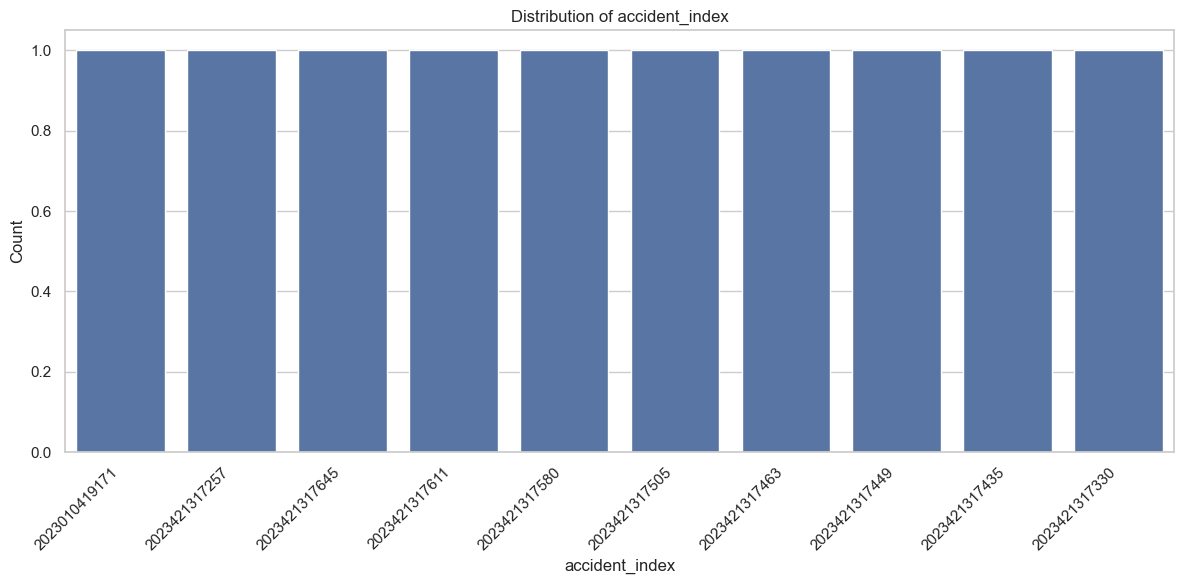

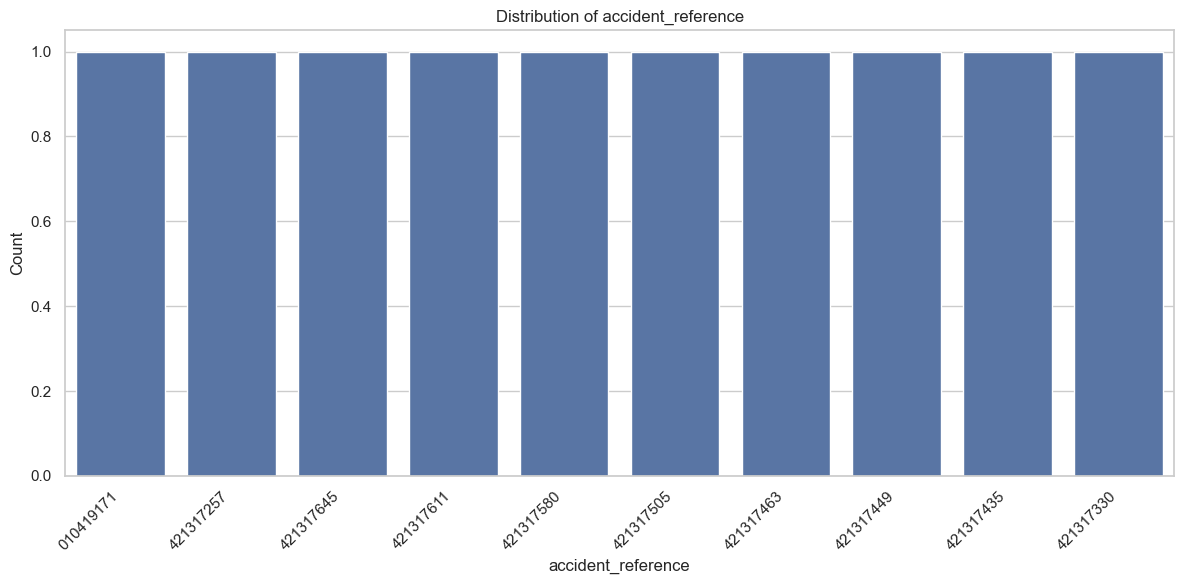

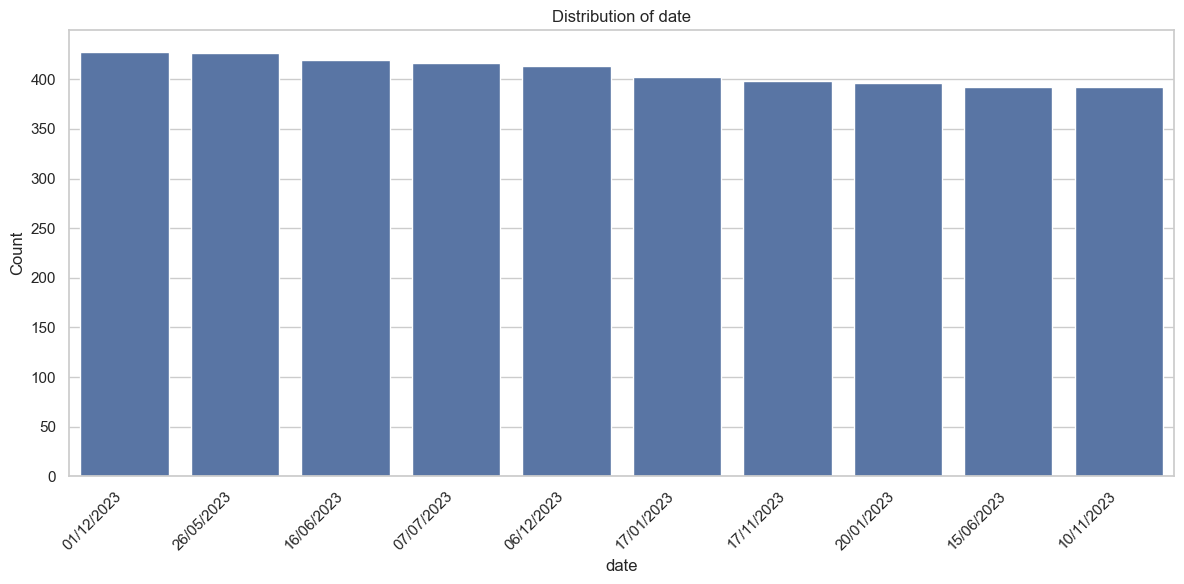

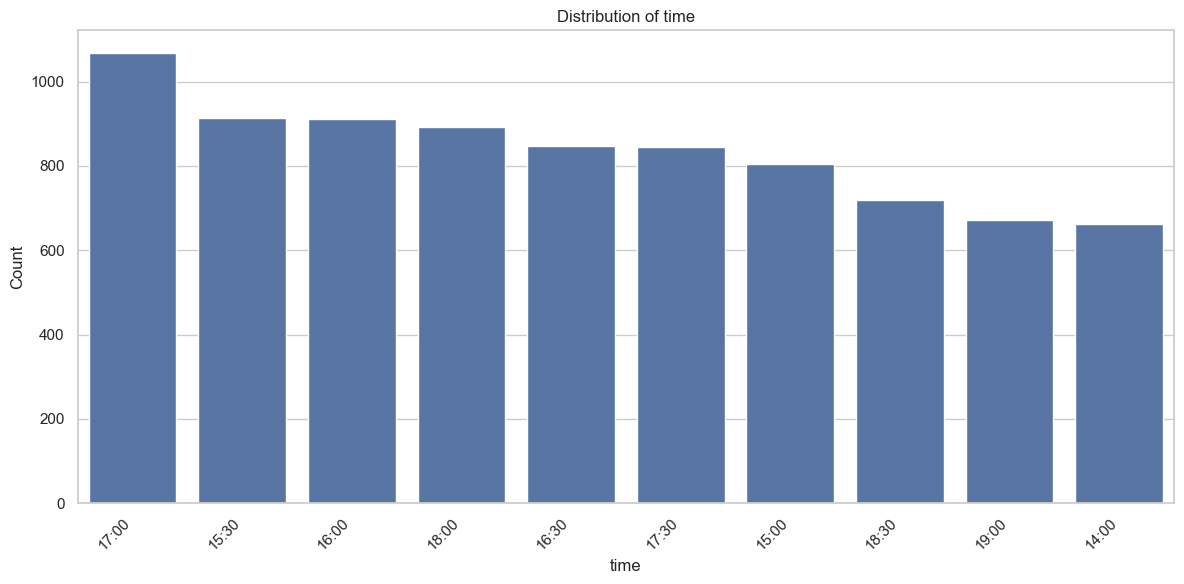

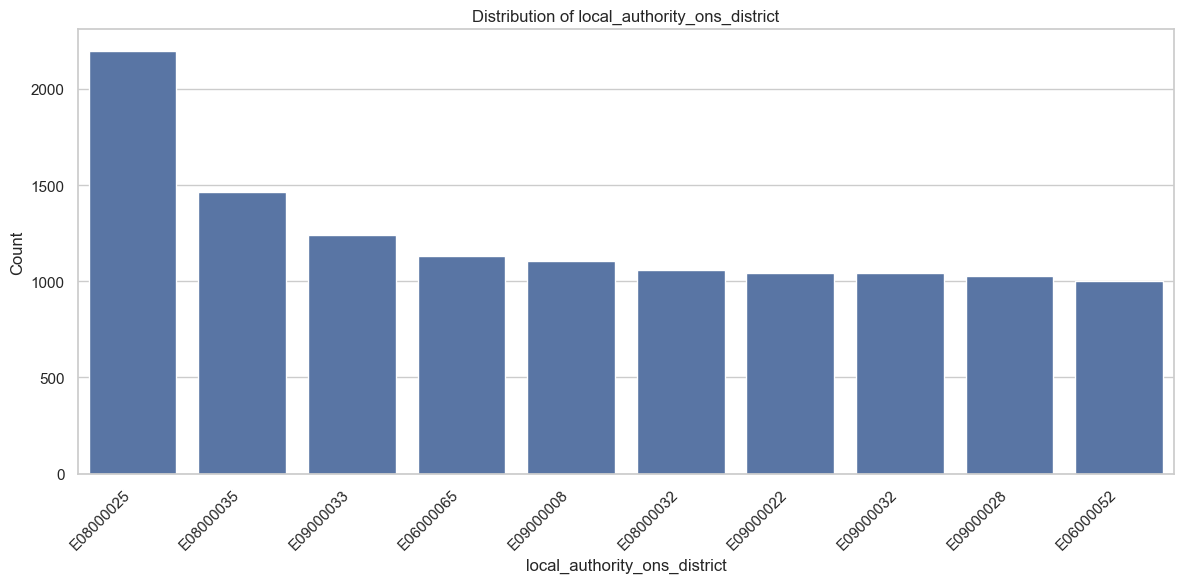

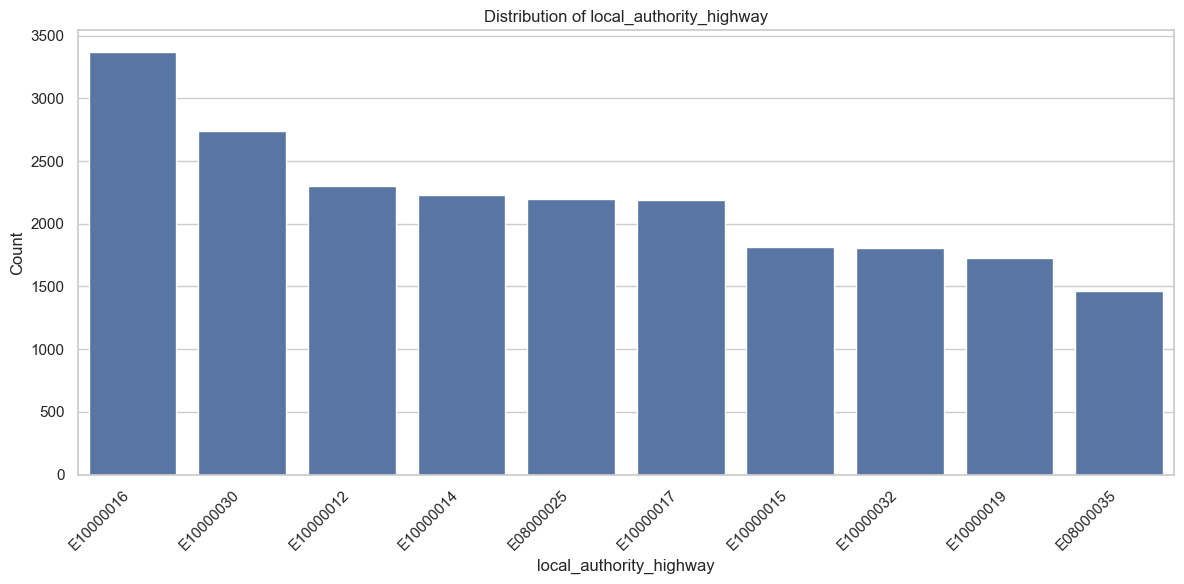

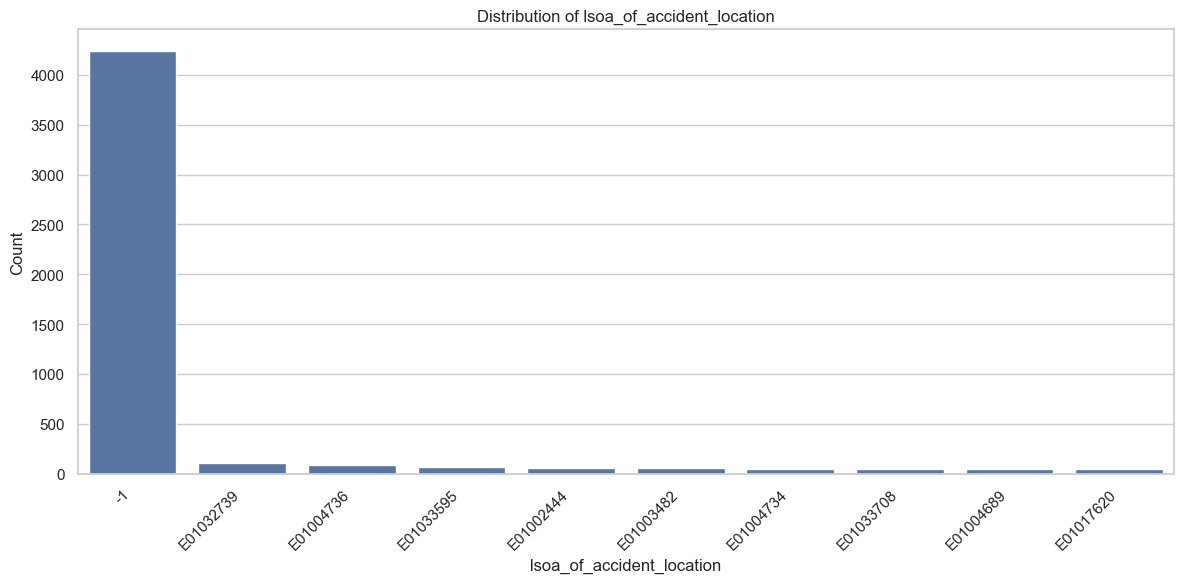

In [55]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    value_counts = df[col].value_counts()
    if len(value_counts) > 10:
        value_counts = value_counts.head(10)
    
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 1C. Correlation Matrices

We use Pearson, Spearman, and Kendall correlations to:
- Identify multicollinearity
- Understand relationships between numerical features
This informs decisions in feature selection and modeling.

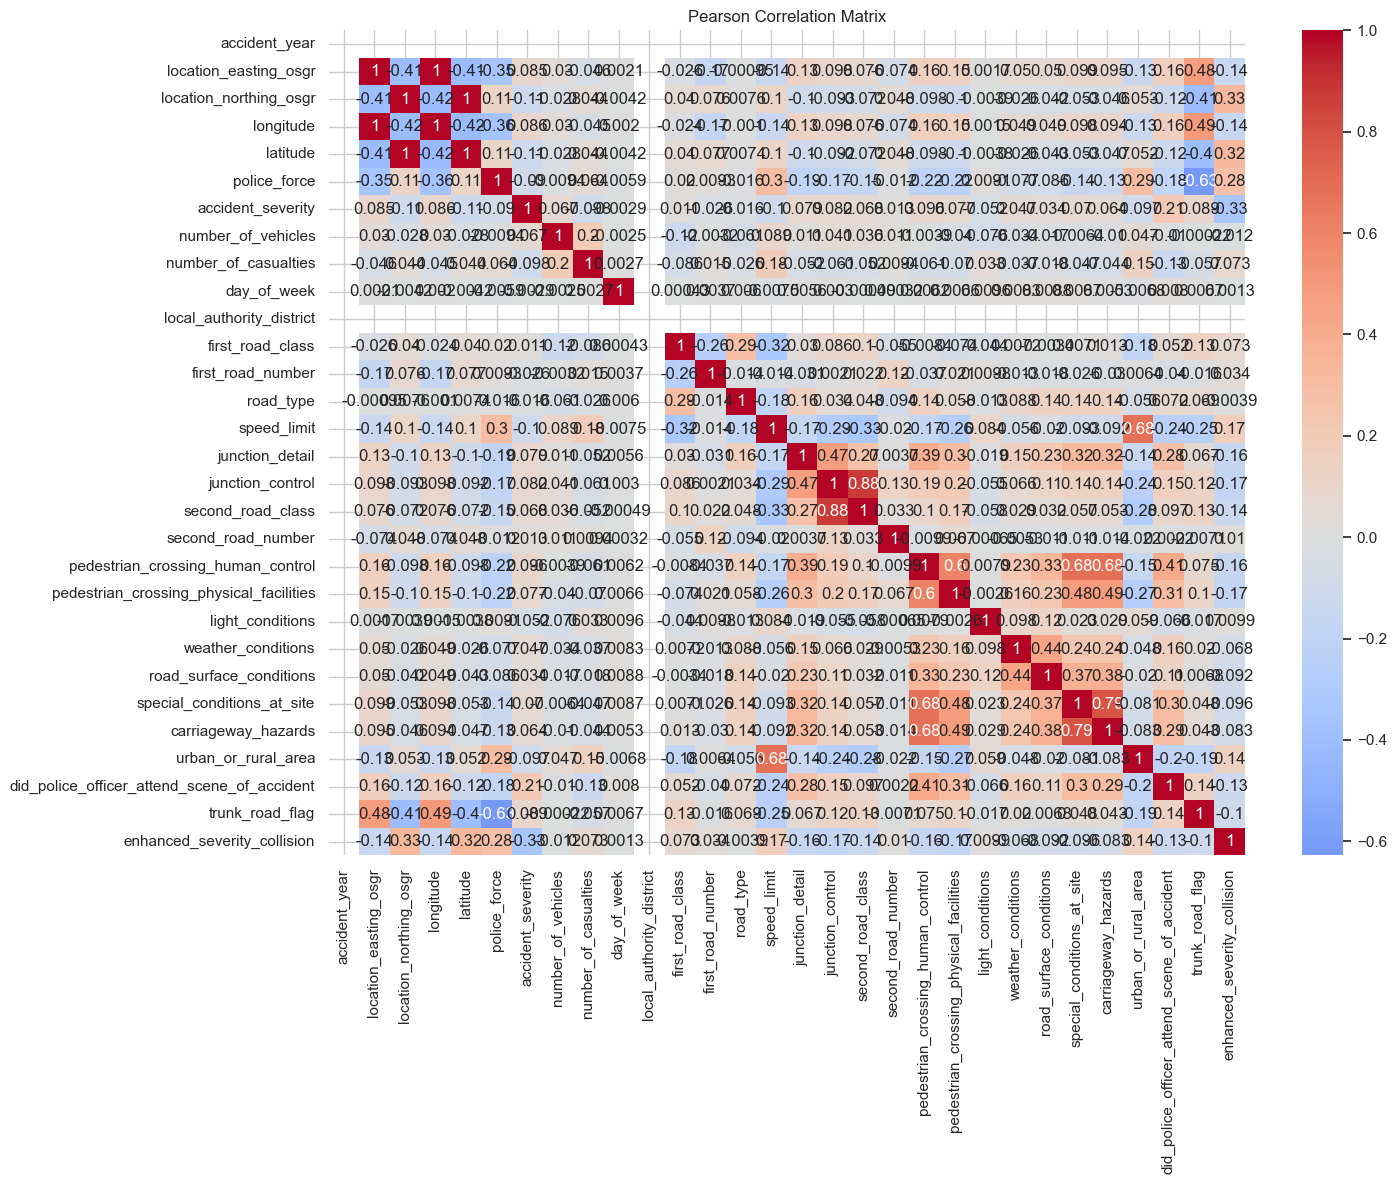

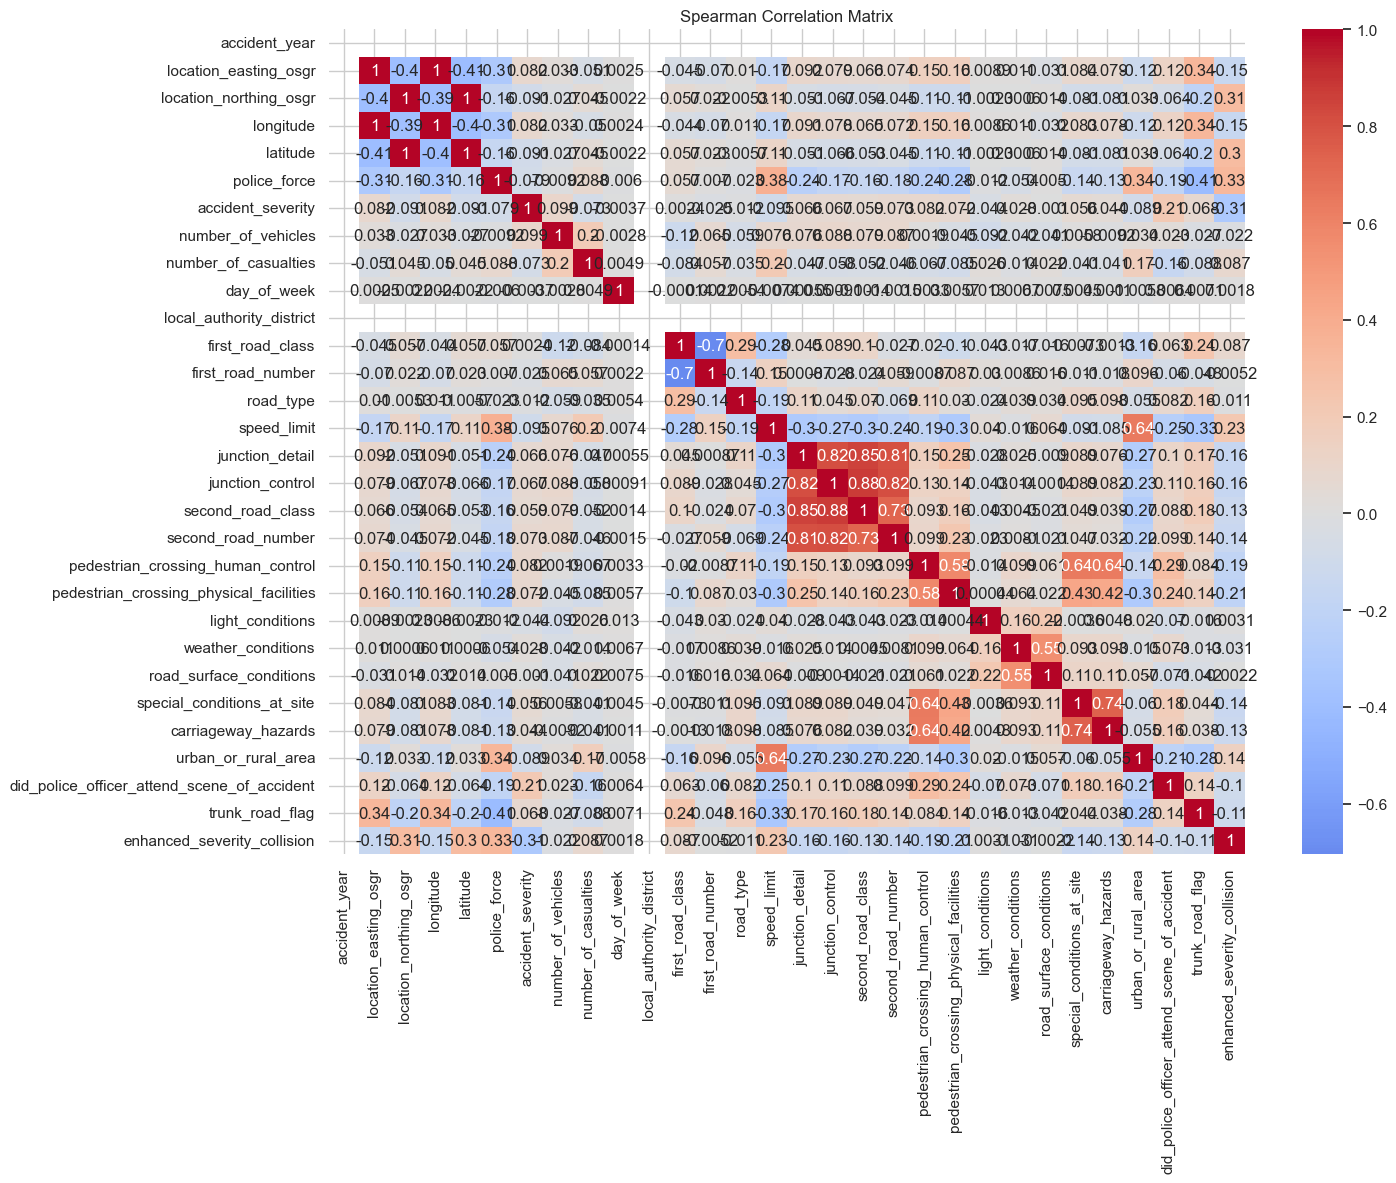

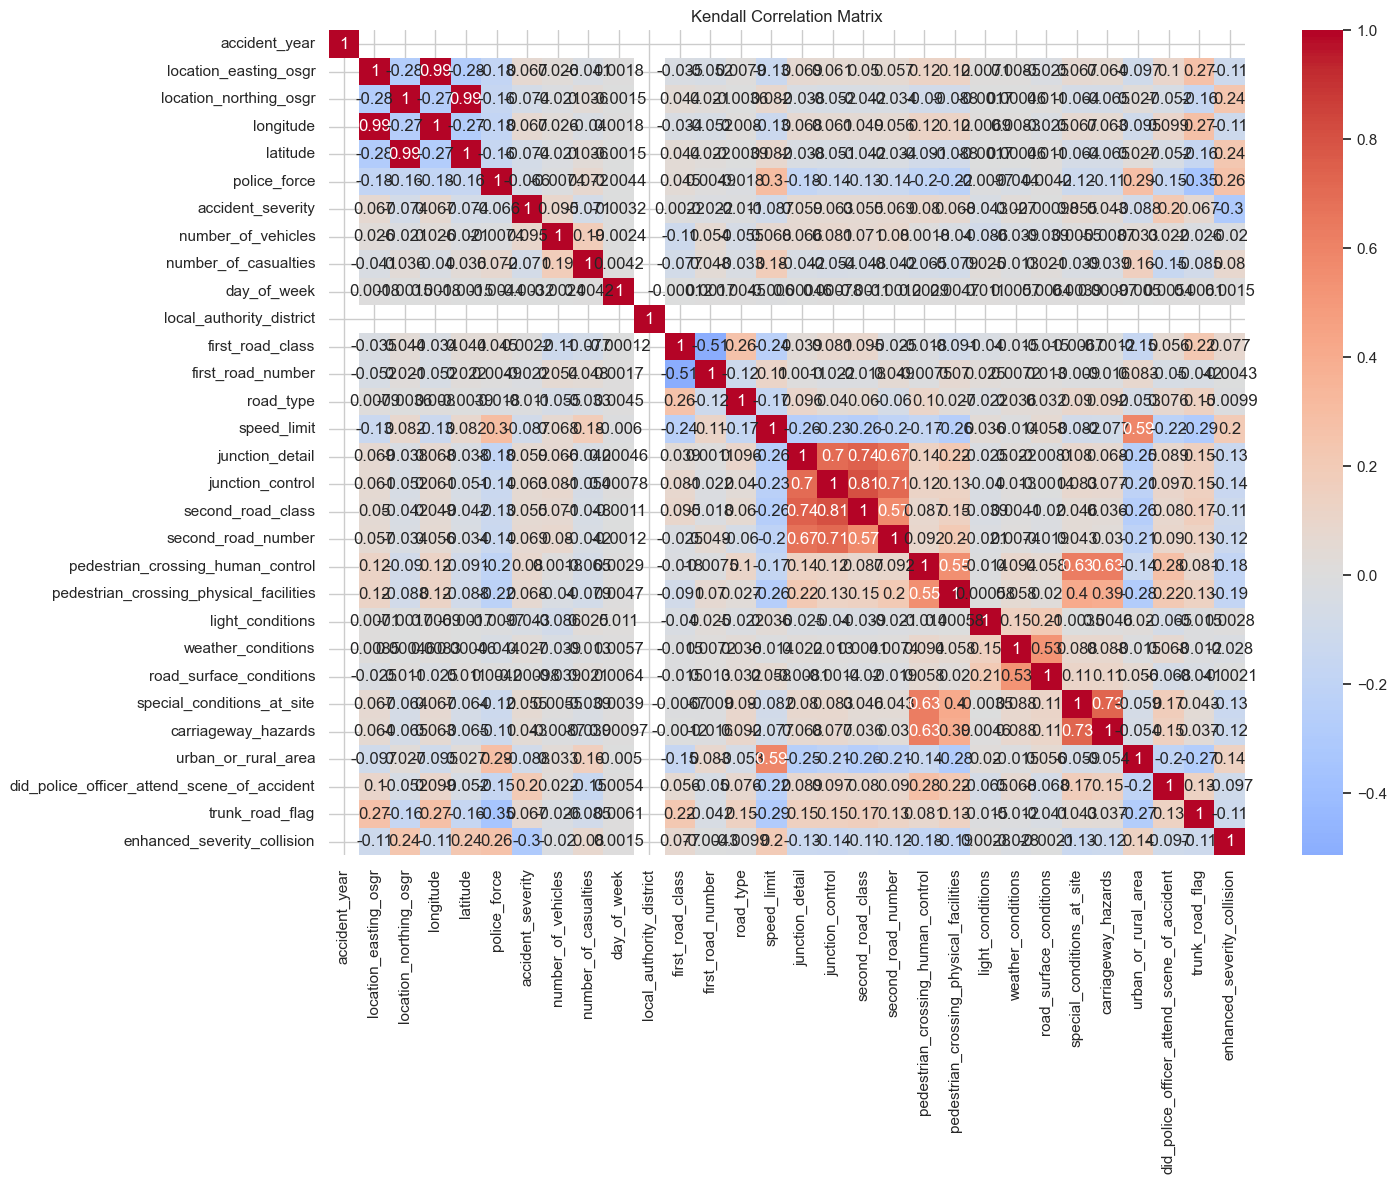

In [56]:
correlation_methods = ['pearson', 'spearman', 'kendall']

for method in correlation_methods:
    corr_matrix = df[numerical_cols].corr(method=method)
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'{method.capitalize()} Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 2. Data Cleaning

To ensure the dataset is reliable and ready for modelling, we perform a series of cleaning steps:
- Remove rows with missing essential geolocation data
- Replace special placeholder values (e.g., `-1`) with `NaN`
- Standardise string-based columns (e.g., trim spaces, convert to lowercase)
These steps improve data quality and prepare the dataset for further analysis and modelling.

In [57]:
# Remove rows with missing essential location information
location_cols = ['location_easting_osgr', 'location_northing_osgr', 'latitude', 'longitude']
initial_rows = len(df)
df = df.dropna(subset=location_cols)
rows_removed = initial_rows - len(df)

print(f"Rows removed due to missing location data: {rows_removed}")
print(f"Remaining rows after location data cleaning: {len(df)}")

# Replace -1 with NaN for numeric columns (e.g., placeholder values)
numeric_cols = df.select_dtypes(include=[np.number]).columns
replacements = {}
for col in numeric_cols:
    count = (df[col] == -1).sum()
    if count > 0:
        df[col] = df[col].replace(-1, np.nan)
        replacements[col] = count

print("\nColumns where -1 values were replaced with NaN:")
for col, count in replacements.items():
    print(f"{col}: {count} replacements")

# Standardise string columns: lowercase and strip whitespace
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.strip().str.lower()

print("\nUnique value counts in string columns after cleaning:")
for col in object_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Show top 10 most frequent values in each categorical column
print("\nTop 10 most frequent values for each categorical column:")
for col in object_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))

Rows removed due to missing location data: 12
Remaining rows after location data cleaning: 104246

Columns where -1 values were replaced with NaN:
local_authority_district: 104246 replacements
junction_detail: 1 replacements
junction_control: 43790 replacements
second_road_class: 84 replacements
second_road_number: 43041 replacements
pedestrian_crossing_human_control: 2789 replacements
pedestrian_crossing_physical_facilities: 2783 replacements
road_surface_conditions: 1064 replacements
special_conditions_at_site: 3116 replacements
carriageway_hazards: 3127 replacements
trunk_road_flag: 7482 replacements
enhanced_severity_collision: 48229 replacements

Unique value counts in string columns after cleaning:
accident_index: 104246 unique values
accident_reference: 104246 unique values
date: 365 unique values
time: 1440 unique values
local_authority_ons_district: 351 unique values
local_authority_highway: 208 unique values
lsoa_of_accident_location: 26838 unique values

Top 10 most frequent

## 3. Principal Component Analysis (PCA)

PCA helps us understand the directions of maximum variance in the dataset. This can guide dimensionality reduction and highlight which features contribute most to variability in the data.
Here, we:
- Select and standardise numerical features
- Apply PCA
- Plot the explained variance
- Output the contribution of each feature to the principal components

In [60]:
# Select numerical columns and fill missing values with the mean
df_pca_input = df[numeric_cols].fillna(df[numeric_cols].mean())

# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca_input)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.png')
plt.show()

# Create DataFrame for PCA feature importance
pca_feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_cols
)

# Save for reference
pca_feature_importance.to_csv('outputs/pca_feature_importance.csv')

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values